# **Loading Libary and Dataset**

In [ ]:
!pip install nltk

In [ ]:
# imports the essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
from sklearn.manifold import TSNE

In [ ]:
import re
import random
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from nltk.util import ngrams
from collections import Counter
from collections import Counter, defaultdict


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the dataset from the specified path
df = pd.read_csv('/content/drive/MyDrive/ML Project Dataset/fake_real.csv', sep=',', encoding='utf-8', quotechar='"')
# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,Content,Title,Type
0,0,new york reuters us environmental group sierra...,politicsNews,true
1,1,washington reuters us air force asked industry...,politicsNews,true
2,2,saturday paul ryan posted photo instagram phot...,News,fake
3,3,america keeps waiting word hillary indicted ob...,politics,fake
4,4,religion peace ht weasel zippers,left-news,fake


In [ ]:
# Display the last few rows of the DataFrame
df.tail()

,Unnamed: 0,Content,Title,Type
44893,44893,new york reuters myanmar national security adv...,worldnews,true
44894,44894,reckless hillary cared less seriousness exposi...,politics,fake
44895,44895,montevideo reuters lucia topolansky uruguay se...,worldnews,true
44896,44896,donald trump getting heavy media coverage late...,News,fake
44897,44897,jakarta reuters indonesian security forces eas...,worldnews,true


# **Data Preprocessing:**


In [ ]:
# Get the dimensions of the DataFrame (rows, columns)
print("\nDimensions of the DataFrame:")
df.shape


Dimensions of the DataFrame:


(44898, 4)

In [ ]:
# Get a concise summary of the DataFrame including column data types and non-null values
print("\nSummary of the DataFrame:")
df.info()


Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44898 non-null  int64 
 1   Content     44266 non-null  object
 2   Title       44898 non-null  object
 3   Type        44898 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
# Check for missing values in each column
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


Unnamed: 0      0
Content       632
Title           0
Type            0
dtype: int64

In [ ]:
# Remove rows with missing values
df= df.dropna()

# Fill missing values in 'Content' column with an empty string
df['Content'].fillna('', inplace=True)

# Fill missing values in 'Type' column with the mode
mode_value = df['Type'].mode()[0]
df['Type'].fillna(mode_value, inplace=True)

In [ ]:
df.isnull().sum()

Unnamed: 0    0
Content       0
Title         0
Type          0
dtype: int64

In [ ]:
# Summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
df.describe()


Summary statistics of numerical columns:


,Unnamed: 0
count,44266.000000
mean,22444.399901
std,12960.235898
min,0.000000
25%,11218.250000
50%,22443.500000
75%,33667.750000
max,44897.000000


In [ ]:
df.columns

Index(['Unnamed: 0', 'Content', 'Title', 'Type'], dtype='object')

In [ ]:
# Display unique values in the 'type' column
print("\nUnique values in the 'type' column:")
df['Type'].unique()


Unique values in the 'type' column:


array(['true', 'fake'], dtype=object)

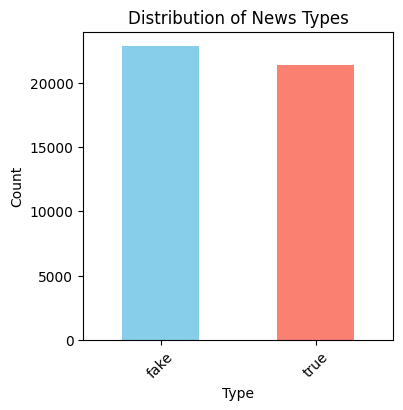

In [ ]:
# Explore unique values in the 'Type' column
type_counts = df['Type'].value_counts()

# Define colors for different types
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral']

# Plot the counts
plt.figure(figsize=(4, 4))
type_counts.plot(kind='bar', color=colors)
plt.title('Distribution of News Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

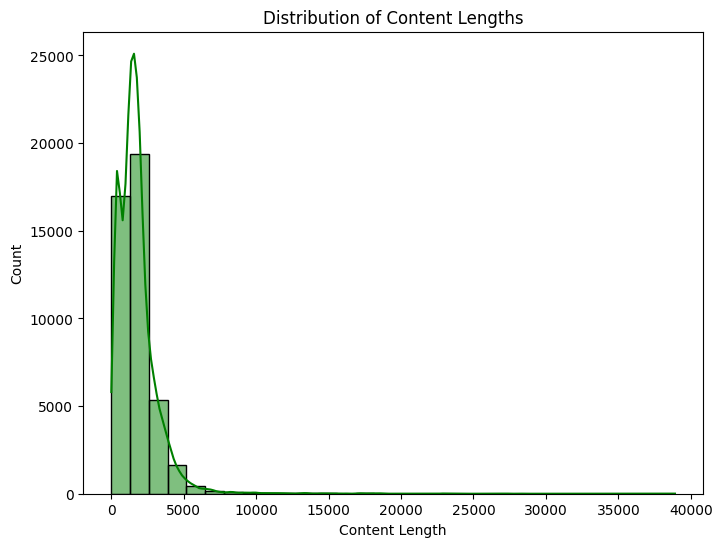

In [ ]:
# Visualize the distribution of content lengths using a histogram
df['Content_Length'] = df['Content'].str.len()
plt.figure(figsize=(8, 6))
sns.histplot(df['Content_Length'], bins=30, kde=True, color='green')
plt.title('Distribution of Content Lengths')
plt.xlabel('Content Length')
plt.ylabel('Count')
plt.show()

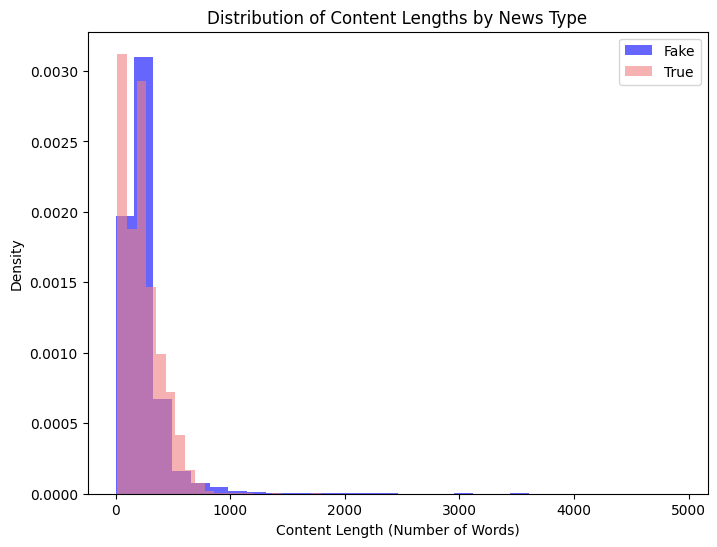

In [ ]:
# Calculate the length of each article (number of words)
df['Content_Length'] = df['Content'].apply(lambda x: len(x.split()))

# Define colors for fake and true news
fake_color = 'blue'
true_color = 'lightcoral'

# Filter fake and true news
fake_news = df[df['Type'] == 'fake']
true_news = df[df['Type'] == 'true']

# Plot histograms for fake and true news
plt.figure(figsize=(8, 6))
plt.hist(fake_news['Content_Length'], bins=30, color=fake_color, label='Fake', alpha=0.6, density=True)
plt.hist(true_news['Content_Length'], bins=30, color=true_color, label='True', alpha=0.6, density=True)

plt.title('Distribution of Content Lengths by News Type')
plt.xlabel('Content Length (Number of Words)')
plt.ylabel('Density')
plt.legend()
plt.show()

**Clean the text data**

In [ ]:
# Check if the Content column is of string data type
if df['Content'].dtype == 'object':
    print("The 'Content' column is of string data type.")
else:
    print("The 'Content' column is not of string data type.")

The 'Content' column is of string data type.


In [ ]:
# convert Content column to string
df['Content'] = df['Content'].astype(str)

In [ ]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text

# Apply the function to remove HTML tags from the 'Content' column
df['Content'] = df['Content'].apply(remove_html_tags)

**processing the text data**


In [ ]:
# Function to remove punctuation marks from text
def remove_punctuation(text):
    # Define the regex pattern to match punctuation marks
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation marks with empty string
    cleaned_text = re.sub(punctuation_pattern, '', text)
    return cleaned_text

# Apply the function to remove punctuation from the 'Content' column
df['Content'] = df['Content'].apply(remove_punctuation)

In [ ]:
# Function to remove special characters and numbers from text
def remove_special_characters_and_numbers(text):
    # Define the regex pattern to match special characters and numbers
    special_characters_and_numbers_pattern = r'[^a-zA-Z\s]'
    # Replace special characters and numbers with empty string
    cleaned_text = re.sub(special_characters_and_numbers_pattern, '', text)
    return cleaned_text

# Apply the function to remove special characters and numbers from the 'Content' column
df['Content'] = df['Content'].apply(remove_special_characters_and_numbers)

In [ ]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to convert text to lowercase for the 'Content' column
df['Content'] = df['Content'].apply(convert_to_lowercase)

In [ ]:
# Function to tokenize the text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to tokenize the 'Content' column
df['Tokens'] = df['Content'].apply(tokenize_text)


In [ ]:
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply the function to remove stopwords from the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(remove_stopwords)

In [ ]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the function to lemmatize the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)

In [ ]:
# Function to join tokens back into a single string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the function to join the processed tokens in the 'Tokens' column
df['Processed_Content'] = df['Tokens'].apply(join_tokens)

In [ ]:
df.head()

,Unnamed: 0,Content,Title,Type,Content_Length,Tokens,Processed_Content
0,0,new york reuters us environmental group sierra...,politicsNews,true,294,"[new, york, reuters, u, environmental, group, ...",new york reuters u environmental group sierra ...
1,1,washington reuters us air force asked industry...,politicsNews,true,240,"[washington, reuters, u, air, force, asked, in...",washington reuters u air force asked industry ...
2,2,saturday paul ryan posted photo instagram phot...,News,fake,160,"[saturday, paul, ryan, posted, photo, instagra...",saturday paul ryan posted photo instagram phot...
3,3,america keeps waiting word hillary indicted ob...,politics,fake,641,"[america, keep, waiting, word, hillary, indict...",america keep waiting word hillary indicted oba...
4,4,religion peace ht weasel zippers,left-news,fake,5,"[religion, peace, ht, weasel, zipper]",religion peace ht weasel zipper


# **Visualization**

**Basic Statistics**

In [ ]:
# Calculate basic statistics
num_documents = len(df)
avg_length = df['Processed_Content'].apply(len).mean()
max_length = df['Processed_Content'].apply(len).max()
min_length = df['Processed_Content'].apply(len).min()

# Print basic statistics
print("Basic Statistics:")
print("Number of documents:", num_documents)
print("Average length of documents:", avg_length)
print("Maximum length of documents:", max_length)
print("Minimum length of documents:", min_length)



Basic Statistics:
Number of documents: 44266
Average length of documents: 1724.3534992996883
Maximum length of documents: 37883
Minimum length of documents: 4


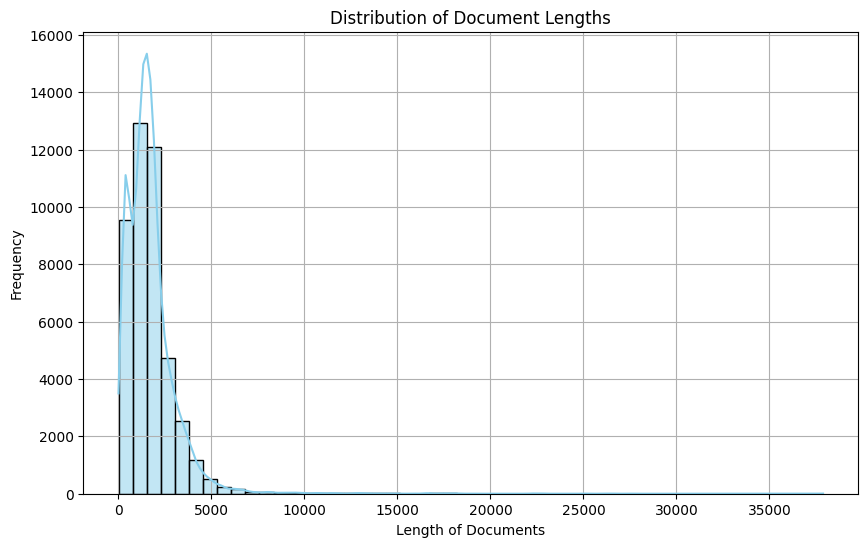

In [ ]:
# Plot distribution of document lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['Processed_Content'].apply(len), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Document Lengths')
plt.xlabel('Length of Documents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Vocabulary Analysis**

In [ ]:
# Sample a subset of the data for analysis
sampled_indices = random.sample(range(len(df)), min(1000, len(df)))  # Adjust sample size as needed
sampled_data = df.iloc[sampled_indices]

# Initialize an empty defaultdict to store word frequencies
word_freq = defaultdict(int)

# Initialize variables to store vocabulary size and rare word count
vocabulary_size = 0
num_rare_words = 0

# Set the batch size for updating word frequencies
batch_size = 1000  # Adjust as needed

# Iterate over each document to update word frequencies incrementally
for i, tokens in enumerate(sampled_data['Tokens'], start=1):
    for token in tokens:
        word_freq[token] += 1  # Update word frequencies

    # Update vocabulary size and count rare words after processing a batch of documents
    if i % batch_size == 0 or i == len(sampled_data):
        vocabulary_size = len(word_freq)
        num_rare_words = sum(1 for freq in word_freq.values() if freq == 1)

# Output vocabulary statistics
print("Size of Vocabulary:", vocabulary_size)
print("Number of Rare Words (frequency = 1):", num_rare_words)

Size of Vocabulary: 23662
Number of Rare Words (frequency = 1): 11811


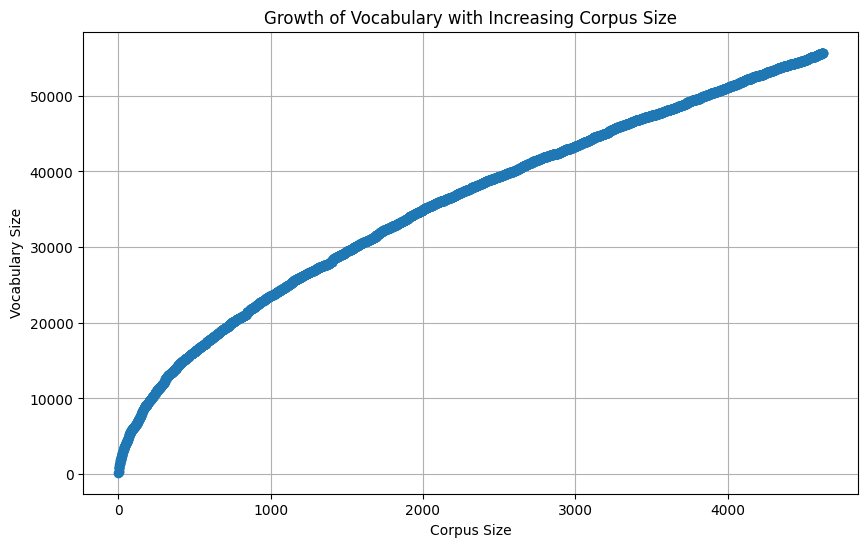

In [ ]:
# Plot the growth of vocabulary with increasing corpus size
plt.figure(figsize=(10, 6))
plt.plot(corpus_sizes, vocabulary_sizes, marker='o')
plt.title('Growth of Vocabulary with Increasing Corpus Size')
plt.xlabel('Corpus Size')
plt.ylabel('Vocabulary Size')
plt.grid(True)
plt.show()

# Plot the distribution of rare words versus common words


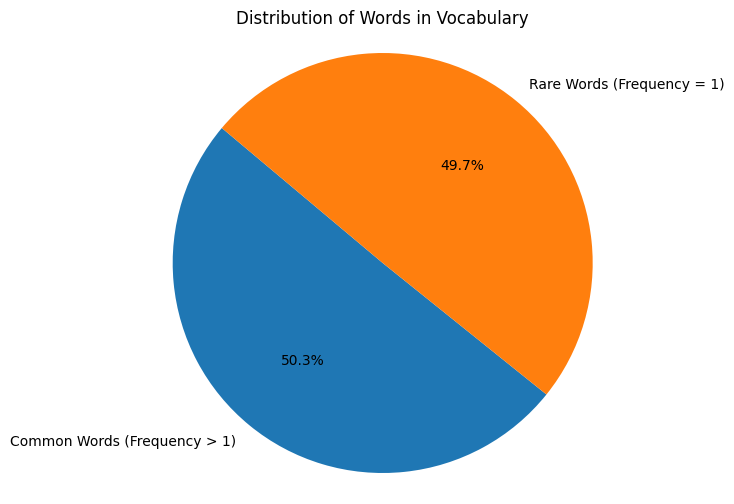

In [ ]:
labels = ['Common Words (Frequency > 1)', 'Rare Words (Frequency = 1)']
sizes = [vocabulary_size - num_rare_words, num_rare_words]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Words in Vocabulary')
plt.axis('equal')
plt.show()

**Sentiment Analysis**

In [ ]:
# Function to calculate sentiment score using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each document
df['Sentiment'] = df['Content'].apply(get_sentiment)

 # Print sentiment scores for the first few documents
df['Sentiment'].head()


0    0.080455
1    0.057019
2    0.039107
3    0.066206
4    0.000000
Name: Sentiment, dtype: float64

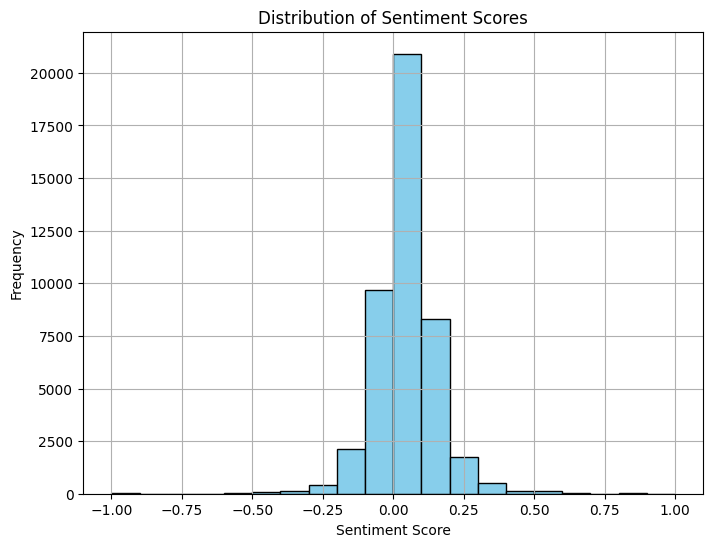

In [ ]:
# Visualize the distribution of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)

**Word Frequency Analysis**

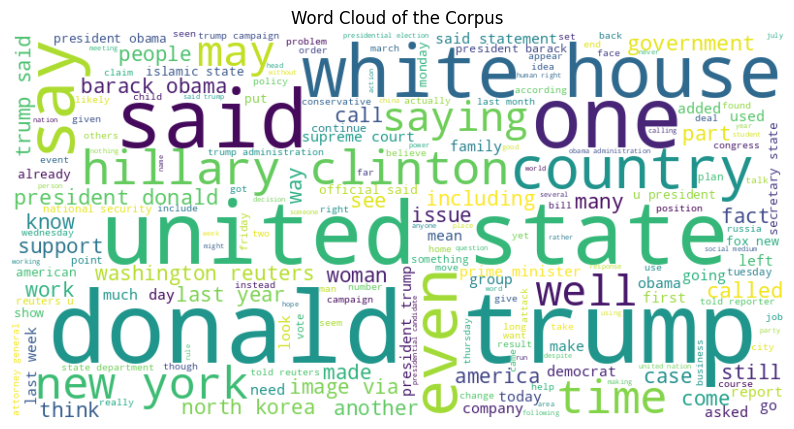

In [ ]:
# Combine all tokens into a single list
all_tokens = [token for sublist in df['Tokens'] for token in sublist]

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Corpus')
plt.show()

In [ ]:
from collections import Counter

# Calculate word frequency
word_freq = Counter(all_tokens)

# Get top N most common words
top_n_words = word_freq.most_common(20)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar([word[0] for word in top_n_words], [word[1] for word in top_n_words])
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

NameError: name 'df' is not defined

**WordCloud for fake and real news separately**

In [ ]:
# Filter the DataFrame for fake news
fake_df = df[df['Type'] == 'fake']

# Filter the DataFrame for true news
true_df = df[df['Type'] == 'true']

# Create Word Cloud for fake news
fake_tokens = [token for sublist in fake_df['Tokens'] for token in sublist]
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fake_tokens))

# Create Word Cloud for true news
true_tokens = [token for sublist in true_df['Tokens'] for token in sublist]
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(true_tokens))


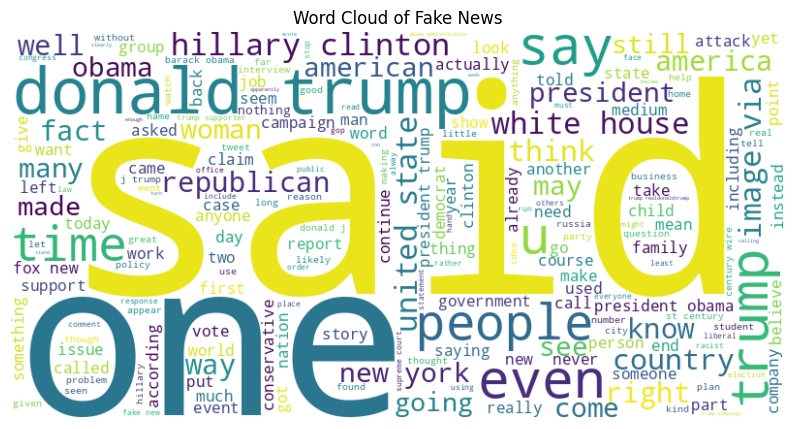

In [ ]:
# Display the Word Cloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Fake News')
plt.show()

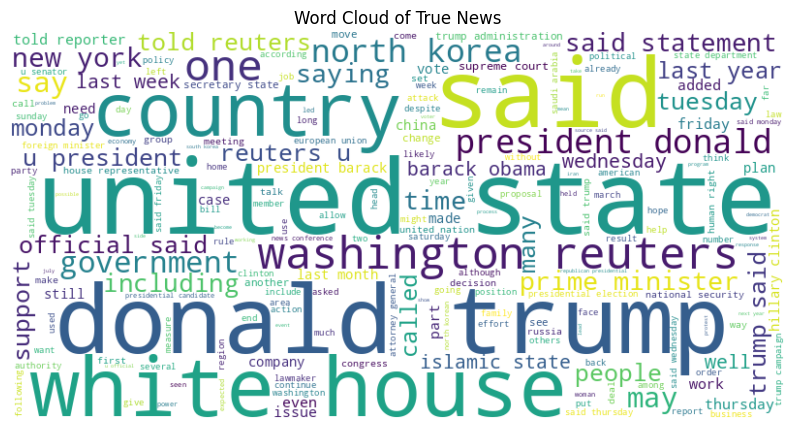

In [ ]:
# Display the Word Cloud for true news
plt.figure(figsize=(10, 6))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of True News')
plt.show()

**Text Length Analysis**

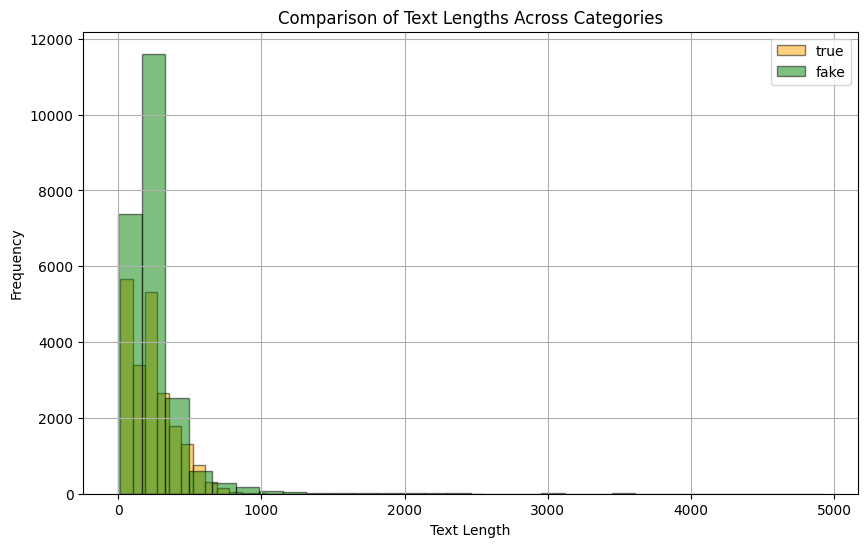

In [ ]:
# Compare the lengths of documents across different categories or labels
plt.figure(figsize=(10, 6))
for label, color in zip(df['Type'].unique(), ['orange', 'green']):
    subset = df[df['Type'] == label]
    plt.hist(subset['Content_Length'], bins=30, color=color, alpha=0.5, label=label, edgecolor='black')

plt.title('Comparison of Text Lengths Across Categories')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

**Word Context Analysis**

In [ ]:
# Initialize CountVectorizer to create co-occurrence matrix
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)  # Adjust parameters as needed

# Fit and transform the processed text data to generate co-occurrence matrix
co_occurrence_matrix = vectorizer.fit_transform(df['Processed_Content'])

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate co-occurrence matrix
co_occurrence_matrix = (co_occurrence_matrix.T * co_occurrence_matrix)  # Symmetric matrix

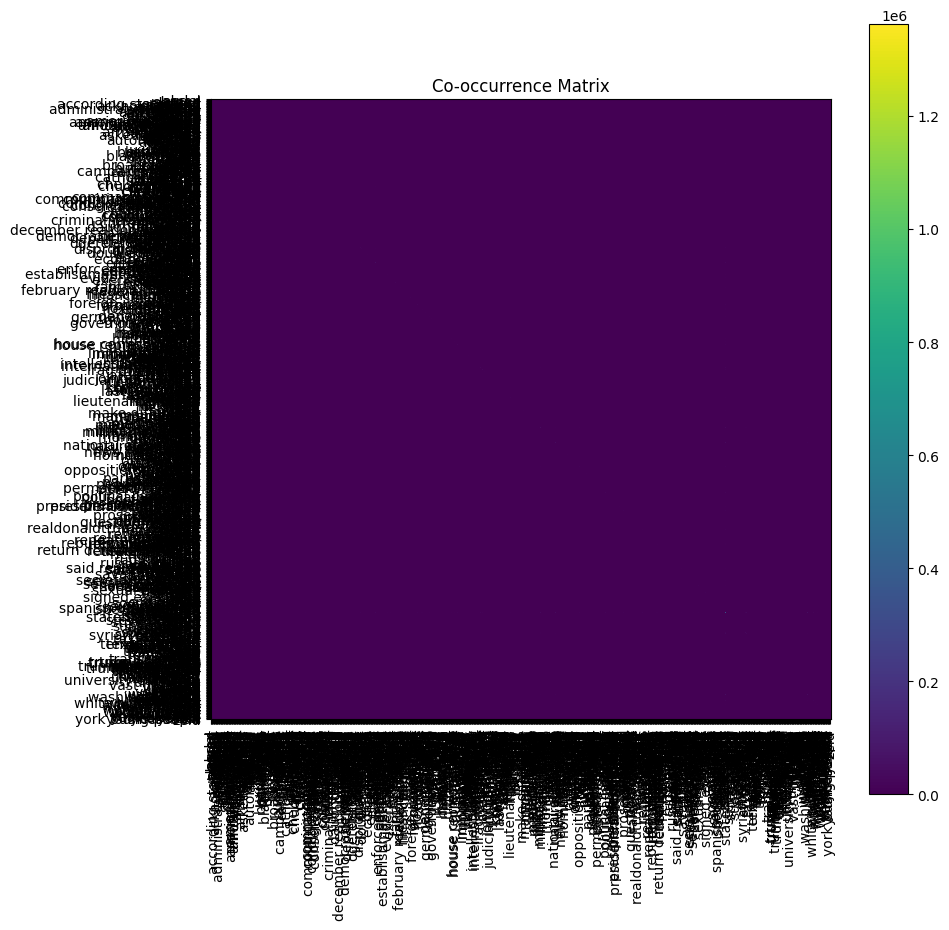

In [ ]:
# Visualize co-occurrence matrix or word-context matrix
plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix.toarray(), cmap='viridis', interpolation='nearest')
plt.title('Co-occurrence Matrix')
plt.colorbar()
# Customizing tick labels
subset_feature_names = feature_names[::10]  # Select every 10th feature name
plt.xticks(ticks=range(0, len(feature_names), 10), labels=subset_feature_names, rotation=90)
plt.yticks(ticks=range(0, len(feature_names), 10), labels=subset_feature_names)
plt.show()

**N-gram Analysis**

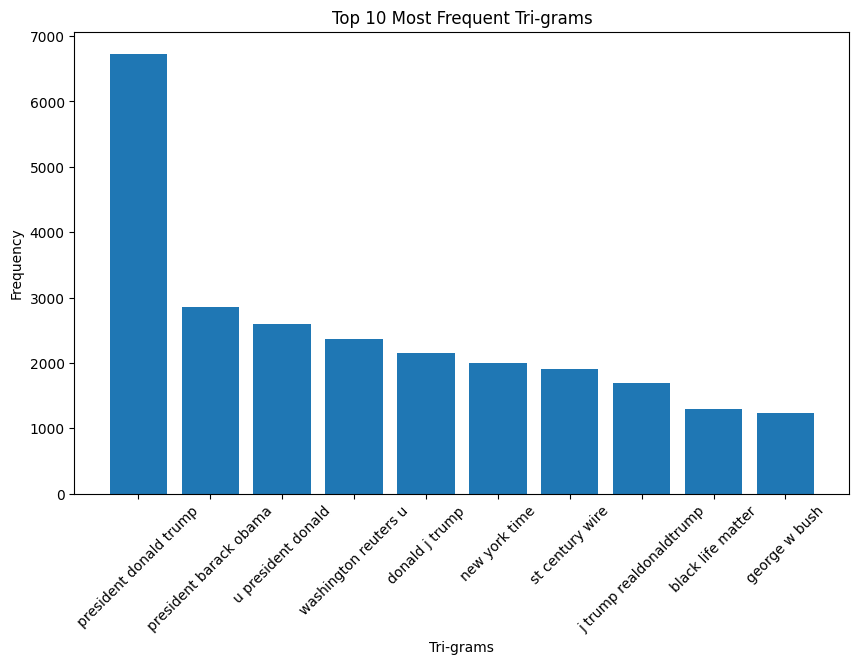

In [ ]:
# Function to generate n-grams
def generate_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Function to analyze n-gram frequency
def analyze_ngram_frequency(data, n):
    ngram_freq = Counter()
    for tokens in data:
        ngrams_list = generate_ngrams(tokens, n)
        ngram_freq.update(ngrams_list)
    return ngram_freq

# Analyze tri-gram frequency
trigram_freq = analyze_ngram_frequency(df['Tokens'], 3)

# Get top N most common tri-grams
top_n_trigrams = trigram_freq.most_common(10)

# Plot bar chart for top N most common tri-grams
plt.figure(figsize=(10, 6))
plt.bar([' '.join(ngram[0]) for ngram in top_n_trigrams], [ngram[1] for ngram in top_n_trigrams])
plt.title('Top 10 Most Frequent Tri-grams')
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# **Feature Extraction**

**Bag-of-Words (BoW)**

In [ ]:
# Bag-of-Words (BoW)
def bow_representation(text_data):
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(text_data)
    return bow_matrix, vectorizer

In [ ]:
# Bag-of-Words (BoW) representation
bow_matrix, bow_vectorizer = bow_representation(df['Processed_Content'])

NameError: name 'df' is not defined

In [ ]:
# Convert the 'Processed_Content' column to a list of strings
corpus = df['Processed_Content'].tolist()

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus to create the BoW representation
bow_matrix = vectorizer.fit_transform(corpus)

# Convert the BoW matrix to a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the BoW DataFrame
print(bow_df)

In [ ]:
# Plot heatmap of BoW representation
plt.figure(figsize=(10, 8))
sns.heatmap(bow_df.iloc[:100, :100], cmap='Blues')  # Adjust the range as needed
plt.title('Bag-of-Words Representation')
plt.xlabel('Words')
plt.ylabel('Documents')
plt.show()

In [ ]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the processed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Content'])

# Convert TF-IDF matrix to DataFrame for easier manipulation (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Print the TF-IDF DataFrame
print(tfidf_df)
